In [1]:
%load_ext autoreload
%autoreload 2

import sys, os, shutil
ROOT_PROJECT =  os.path.join(os.path.normpath(os.path.join(os.getcwd(), "../")))
sys.path[0] = ROOT_PROJECT

import matplotlib
from matplotlib import colors, colorbar
from matplotlib import cm
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats, clear_output

import matplotlib_inline.backend_inline
ipython_format = "retina"
if isinstance(ipython_format, str):
    ipython_format = [ipython_format]
matplotlib_inline.backend_inline.set_matplotlib_formats(*ipython_format)

# plt.style.use('seaborn-whitegrid')
plt.style.use('science')
plt.rcParams['figure.figsize'] = (12.0, 7.0)

from tqdm import tqdm

In [2]:
plt.plot()
plt.close()

In [3]:
from mcbo.utils.general_plot_utils import plot_curves_with_ranked_legends
from mcbo.utils.general_utils import get_cummin

## Custom black-box optimization

$f(x)$ defined on a mixed space.
The first 3 elements of the search space (named $\text{op0}$, $\text{op1}$, $\text{op2}$) are categorical, with categories being the
operators cosinus, sinus, tan, identity, and exponential, and the 3 last elements are numerical elements ($\text{x0}$, $\text{x1}$, $\text{x2}$) taking
values in interval [-1, 1], and the objective function is 
$$f(x) = \text{op0}(\text{x0}) / (1 + \text{op1}(\text{x1})) +
\text{op2}(\text{op2})$$
Additionally we consider the following validity constraint on the search space: $\text{op1} \neq \text{op2}$

##### Task definition

In [4]:
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Optional, Callable
from mcbo.tasks.task_base import TaskBase
from mcbo.optimizers.bo_builder import BoBuilder
from mcbo.optimizers.non_bo.genetic_algorithm import GeneticAlgorithm

class CustomTask(TaskBase):
    op_converter = {'cos': np.cos, 'sin': np.sin, 'exp': np.exp, 'tan': np.tan, 'id': lambda x: x}

    @property
    def name(self) -> str:
        return 'Custom Task'

    def evaluate(self, x: pd.DataFrame) -> np.ndarray:
        y = np.zeros((len(x), 1))  # will be filled with evaluations
        for ind in range(len(x)):
            x_ind = x.iloc[ind].to_dict()  # convert to a dictionary
            ops = [self.op_converter[x_ind[f'op{j}']] for j in range(3)]
            y[ind] = ops[0](x_ind['x0']) / (1 + ops[1](x_ind['x1'])) + ops[2](x_ind['x2'])
        return y

    def get_search_space_params(self) -> List[Dict[str, Any]]:
        params = [{'name': f'op{i}', 'type': 'nominal', 'categories': ['cos', 'sin', 'exp', 'tan', 'id']} for i in range(3)]
        params.extend([{'name': f'x{i}', 'type': 'num', 'lb': -1, 'ub': 1} for i in range(3)])
        return params

    @property
    def input_constraints(self) -> Optional[List[Callable[[Dict], bool]]]:
        def check(x: Dict) -> bool:
            return x["op1"] != x["op2"]
        return [check]


task = CustomTask()
search_space = task.get_search_space()
input_constraints = task.input_constraints

##### Optimizer creation

In [10]:
# ---> Could use a BO optimizer
# bo_builder = BoBuilder(model_id='gp_to', acq_opt_id='is', acq_func_id='ei', tr_id='basic') # Corresponds to Casmopolitan
# opt = bo_builder.build_bo(search_space=task.get_search_space(), n_init=20)

# ---> But it will be faster to run this tuto with cheap optimizer such as GA
opt = GeneticAlgorithm(search_space=search_space, input_constraints=input_constraints)

##### Optimization loop

In [6]:
budget_eval = 200

for _ in tqdm(range(budget_eval)):
    x_next = opt.suggest()
    y_next = task(x_next)
    opt.observe(x_next, y_next)
print(opt.best_x, opt.best_y)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.24it/s]

  op0  op1  op2        x0        x1        x2
0  id  sin  exp -0.975164 -0.986543 -0.909774 -5.476269392805513


##### Get all evaluated points and correponding black-box  value

In [7]:
search_space.inverse_transform(opt.data_buffer.x).head()

,op0,op1,op2,x0,x1,x2
0,cos,sin,id,0.318882,0.969111,0.510711
1,exp,cos,sin,-0.109991,0.873901,0.634522
2,exp,tan,exp,-0.732284,0.121671,0.105216
3,exp,cos,id,-0.359087,-0.413848,-0.062859
4,sin,exp,cos,0.804867,0.827015,0.248001


In [8]:
y = opt.data_buffer.y.numpy()
y[:5]

array([[1.03120828],
       [1.13842603],
       [1.5393748 ],
       [0.3016849 ],
       [1.18870905]])

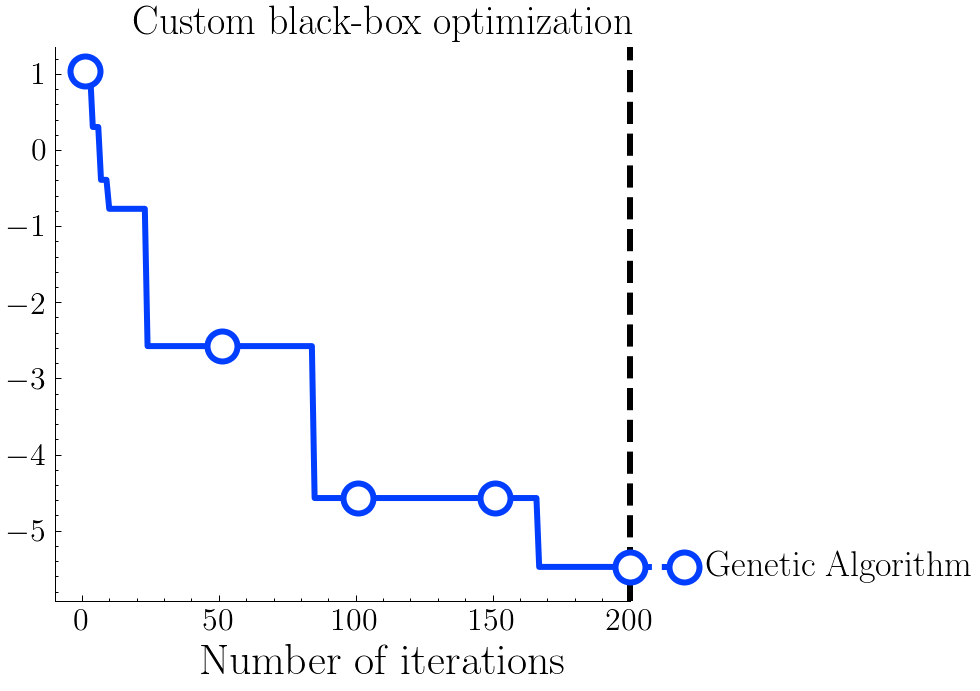

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))

# Get cumulative minimum
regret_y = np.array(get_cummin(y.T))

plot_curves_with_ranked_legends(ax=ax, data_y={opt.name: regret_y}, data_x=np.arange(1, 1 + budget_eval))

ax.set_title(f"Custom black-box optimization", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel("Number of iterations", fontsize=22)
plt.tight_layout()
plt.show()